In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold,StratifiedKFold
import albumentations as A
import cv2
import pandas as pd
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
np.random.seed(42)

In [127]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')

dummy = torch.rand(1, 3, 512, 512)
endpoints = model.extract_endpoints(dummy)

for key in endpoints.keys():
    print(f'{key}: {endpoints[key].shape}, scale: {512/endpoints[key].shape[3]}')

Loaded pretrained weights for efficientnet-b0
reduction_1: torch.Size([1, 16, 256, 256]), scale: 2.0
reduction_2: torch.Size([1, 24, 128, 128]), scale: 4.0
reduction_3: torch.Size([1, 40, 64, 64]), scale: 8.0
reduction_4: torch.Size([1, 112, 32, 32]), scale: 16.0
reduction_5: torch.Size([1, 320, 16, 16]), scale: 32.0
reduction_6: torch.Size([1, 1280, 16, 16]), scale: 32.0


# Format Data

In [2]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

In [22]:
OUT_PATH = '../data/melanoma_dataset/processed_data/'
TABLE_PATH = '../data/split_tables/melanoma/'
os.makedirs(TABLE_PATH,exist_ok=True)

df = pd.read_csv('../data/melanoma_dataset/train.csv')

# enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
# labelencoder = LabelEncoder()
# mapping = labelencoder.fit(labels['dx'])

df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [121]:
df['benign_malignant'].unique()

array(['benign', 'malignant'], dtype=object)

In [23]:
print(f"Target 0: {1-df['target'].mean()}")
print(f"Target 1: {df['target'].mean()}")

Target 0: 0.9823703435367989
Target 1: 0.01762965646320111


In [112]:
images_list_negative = OUT_PATH[1:]+df[df['target']==0]['patient_id']+'/'+df[df['target']==0]['image_name']+'.npy'
images_list_positive = OUT_PATH[1:]+df[df['target']==1]['patient_id']+'/'+df[df['target']==1]['image_name']+'.npy'

images_list_negative = images_list_negative.values
images_list_positive = images_list_positive.values

print(f'Number of positive samples: {images_list_negative.shape[0]}')
print(f'Number of negative samples: {images_list_positive.shape[0]}')

Number of positive samples: 32542
Number of negative samples: 584


In [113]:
patients = [i for i in os.listdir(OUT_PATH) if i.find('.')==-1]

images = []
for patient in patients:
    images += [OUT_PATH[1:]+patient+'/'+i for i in os.listdir(OUT_PATH+patient) if i.find('label.npy')==-1]
len(images)

33126

# Prepare split tables

In [114]:
n_images = len(images_list_negative)+len(images_list_positive)
print(f'Total number of images: {n_images}')

Total number of images: 33126


In [115]:
#create test for negative images
kf = GroupKFold(n_splits=5)


records_test = []
for (train,test) in kf.split(images_list_negative,images_list_negative,images_list_negative):
    
    records_test += images_list_negative[test].tolist()
    
    break

images_list_negative = images_list_negative[train]
    
kf = GroupKFold(n_splits=5)
for (train,test) in kf.split(images_list_positive,images_list_positive,images_list_positive):
    
    records_test += images_list_positive[test].tolist()
    
    break

    

#create test
split = {
        'test': records_test
    }

with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
        json.dump(split, outfile)
        

print(f'Number of unique images, test subset: {len(records_test)}')


images_list_positive = images_list_positive[train]

print(f'Number of positive samples: {images_list_negative.shape[0]}')
print(f'Number of negative samples: {images_list_positive.shape[0]}')

Number of unique images, test subset: 6626
Number of positive samples: 26033
Number of negative samples: 467


In [116]:
#create train and validation
n_patients = [2,4,8]

n_neg = images_list_negative.shape[0]
n_pos = images_list_positive.shape[0]

for i in n_patients:
    
    records_train = []
    records_val = []
    records_pretrain = []
    
    records_train += images_list_negative[:int(n_neg*(i/100))].tolist()
    records_train += images_list_positive[:int(n_pos*(i/100))].tolist()
    
    records_val += images_list_negative[-1*int(n_neg*(2/100)):].tolist()
    records_val += images_list_positive[-1*int(n_pos*(2/100)):].tolist()
    
    records_pretrain += images_list_negative[int(n_neg*(i/100)):].tolist()
    records_pretrain += images_list_positive[int(n_pos*(i/100)):].tolist()
    
    #create split
    split = {
            'train': records_train,
            'val': records_val,
            'pretrain': records_pretrain,
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)



            
    print(f'Number of unique images, train subset: {len(records_train)}')
    print(f'Number of samples, val subset: {len(records_val)}')
    print(f'Number of samples, pretain subset: {len(records_pretrain)}')
    print('#######################################################')

    

Number of unique images, train subset: 529
Number of samples, val subset: 529
Number of samples, pretain subset: 25971
#######################################################
Number of unique images, train subset: 1059
Number of samples, val subset: 529
Number of samples, pretain subset: 25441
#######################################################
Number of unique images, train subset: 2119
Number of samples, val subset: 529
Number of samples, pretain subset: 24381
#######################################################


In [119]:
#create UB

records_train = []
records_val = []

records_train += images_list_negative[:int(n_neg*0.8)].tolist()
records_train += images_list_positive[:int(n_pos*0.8)].tolist()

records_val += images_list_negative[int(n_neg*0.8):].tolist()
records_val += images_list_positive[int(n_pos*0.8):].tolist()



#create split
split = {
        'train': records_train,
        'val': records_val,
    }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
        json.dump(split, outfile)




print(f'Number of unique images, train subset: {len(records_train)}')
print(f'Number of samples, val subset: {len(records_val)}')
print('#######################################################')

Number of unique images, train subset: 21199
Number of samples, val subset: 5301
#######################################################


# Review augs

In [118]:
prob = 1
augs = A.Compose(
                [ 
                    A.HorizontalFlip(p=prob),
                    A.VerticalFlip(p=prob),
                    A.Rotate(limit=90, p=prob),
                    #A.ElasticTransform(alpha=0.1,p=prob),
                    #A.RandomSizedCrop(min_max_height=(120, 120), height=300, width=300, p=prob),
                    #A.RandomGamma(gamma_limit=(80, 120), p=prob)
                    #A.GlassBlur(sigma=10),
                    A.GridDistortion(distort_limit=0.3)
                ]
            )

augmented = augs(image=image)
augmented = augmented['image']


plt.imshow(augmented)

NameError: name 'image' is not defined

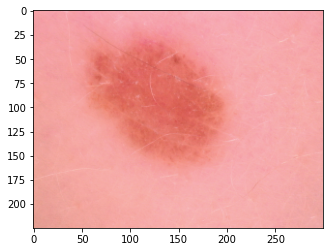

In [186]:
plt.imshow(image)

In [195]:
image.shape

(225, 300, 3)

In [ ]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

In [ ]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')